In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount("/content/drive")

import os

# Base project directory on Google Drive
BASE_DIR = "/content/drive/MyDrive/SkinAI_Project"

# Data dirs
DATA_DIR       = f"{BASE_DIR}/data"
RAW_DIR        = f"{DATA_DIR}/raw"
PROCESSED_DIR  = f"{DATA_DIR}/processed"
SYNTHETIC_DIR  = f"{DATA_DIR}/synthetic"
TEXT_DIR       = f"{DATA_DIR}/text"

# Models + notebooks (for consistency)
MODELS_DIR     = f"{BASE_DIR}/models"
NOTEBOOKS_DIR  = f"{BASE_DIR}/notebooks"

print("BASE_DIR     :", BASE_DIR)
print("RAW_DIR      :", RAW_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("SYNTHETIC_DIR:", SYNTHETIC_DIR)
print("TEXT_DIR     :", TEXT_DIR)
print("MODELS_DIR   :", MODELS_DIR)

print("\nRAW DIR CONTENTS (top-level):")
print(os.listdir(RAW_DIR))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BASE_DIR     : /content/drive/MyDrive/SkinAI_Project
RAW_DIR      : /content/drive/MyDrive/SkinAI_Project/data/raw
PROCESSED_DIR: /content/drive/MyDrive/SkinAI_Project/data/processed
SYNTHETIC_DIR: /content/drive/MyDrive/SkinAI_Project/data/synthetic
TEXT_DIR     : /content/drive/MyDrive/SkinAI_Project/data/text
MODELS_DIR   : /content/drive/MyDrive/SkinAI_Project/models

RAW DIR CONTENTS (top-level):
['train-00000-of-00001', 'ps_md_nlp_skin_data', 'combined_data', 'Skin-Disease-Text-Data', 'Skin_text_classifier']


In [ ]:
import os

# Raw file locations inside data/raw (based on your zip structure)
RAW_SKIN_TEXT_CSV   = f"{RAW_DIR}/Skin_text_classifier/Skin_text_classifier.csv"
RAW_COMBINED_CSV    = f"{RAW_DIR}/combined_data/combined_data.csv"
RAW_NLP_XLSX        = f"{RAW_DIR}/ps_md_nlp_skin_data/ps_md_nlp_skin_data.xlsx"
RAW_HF_PARQUET      = f"{RAW_DIR}/train-00000-of-00001/train-00000-of-00001.parquet"
RAW_TEXT_DIR_LABELS = f"{RAW_DIR}/Skin-Disease-Text-Data"  # folder per disease with .txt files

print("RAW_SKIN_TEXT_CSV   :", RAW_SKIN_TEXT_CSV,   "exists:", os.path.exists(RAW_SKIN_TEXT_CSV))
print("RAW_COMBINED_CSV    :", RAW_COMBINED_CSV,    "exists:", os.path.exists(RAW_COMBINED_CSV))
print("RAW_NLP_XLSX       :", RAW_NLP_XLSX,       "exists:", os.path.exists(RAW_NLP_XLSX))
print("RAW_HF_PARQUET     :", RAW_HF_PARQUET,     "exists:", os.path.exists(RAW_HF_PARQUET))
print("RAW_TEXT_DIR_LABELS:", RAW_TEXT_DIR_LABELS, "exists:", os.path.exists(RAW_TEXT_DIR_LABELS))


RAW_SKIN_TEXT_CSV   : /content/drive/MyDrive/SkinAI_Project/data/raw/Skin_text_classifier/Skin_text_classifier.csv exists: True
RAW_COMBINED_CSV    : /content/drive/MyDrive/SkinAI_Project/data/raw/combined_data/combined_data.csv exists: True
RAW_NLP_XLSX       : /content/drive/MyDrive/SkinAI_Project/data/raw/ps_md_nlp_skin_data/ps_md_nlp_skin_data.xlsx exists: True
RAW_HF_PARQUET     : /content/drive/MyDrive/SkinAI_Project/data/raw/train-00000-of-00001/train-00000-of-00001.parquet exists: True
RAW_TEXT_DIR_LABELS: /content/drive/MyDrive/SkinAI_Project/data/raw/Skin-Disease-Text-Data exists: True


In [ ]:
import pandas as pd

all_dfs = []         # labeled text+label datasets
unlabeled_text = []  # only text (no labels) – optional

# 1) Skin_text_classifier CSV
# Columns: ['Disease name', 'Text'] -> label + text
if os.path.exists(RAW_SKIN_TEXT_CSV):
    try:
        df_skin = pd.read_csv(RAW_SKIN_TEXT_CSV)
        print("Loaded RAW_SKIN_TEXT_CSV:", df_skin.shape)
        print("Columns:", df_skin.columns.tolist())
        df_skin = df_skin.rename(columns={
            "Text": "text",
            "Disease name": "label"
        })
        df_skin["source"] = "Skin_text_classifier"
        all_dfs.append(df_skin[["text", "label", "source"]])
    except Exception as e:
        print("[ERROR] Loading RAW_SKIN_TEXT_CSV:", e)

# 2) combined_data.csv  (NO TRUE LABEL – treat as unlabeled text ONLY)
if os.path.exists(RAW_COMBINED_CSV):
    try:
        df_combined = pd.read_csv(RAW_COMBINED_CSV)
        print("Loaded RAW_COMBINED_CSV:", df_combined.shape)
        print("Columns:", df_combined.columns.tolist())
        # We will treat 'prompt' as extra text only, not used for supervised labels
        df_combined_text = df_combined[["prompt"]].rename(columns={"prompt": "text"})
        df_combined_text["source"] = "combined_data_unlabeled"
        unlabeled_text.append(df_combined_text[["text", "source"]])
    except Exception as e:
        print("[ERROR] Loading RAW_COMBINED_CSV:", e)

# 3) ps_md_nlp_skin_data.xlsx
# Columns: ['Disease Class', 'Disease Definition', 'Patient_Statement', 'File Name']
# -> label = Disease Class, text = Patient_Statement
if os.path.exists(RAW_NLP_XLSX):
    try:
        df_nlp = pd.read_excel(RAW_NLP_XLSX)
        print("Loaded RAW_NLP_XLSX:", df_nlp.shape)
        print("Columns:", df_nlp.columns.tolist())
        df_nlp = df_nlp.rename(columns={
            "Patient_Statement": "text",
            "Disease Class": "label"
        })
        df_nlp["source"] = "ps_md_nlp_skin_data"
        all_dfs.append(df_nlp[["text", "label", "source"]])
    except Exception as e:
        print("[ERROR] Loading RAW_NLP_XLSX:", e)

# 4) train-00000-of-00001.parquet
# Columns: ['question', 'answer', 'condition', 'difficulty', 'source_url']
# -> text = question (patient complaint), label = condition (disease)
if os.path.exists(RAW_HF_PARQUET):
    try:
        df_hf = pd.read_parquet(RAW_HF_PARQUET)
        print("Loaded RAW_HF_PARQUET:", df_hf.shape)
        print("Columns:", df_hf.columns.tolist())
        df_hf = df_hf.rename(columns={
            "question": "text",
            "condition": "label"
        })
        df_hf["source"] = "hf_parquet"
        all_dfs.append(df_hf[["text", "label", "source"]])
    except Exception as e:
        print("[ERROR] Loading RAW_HF_PARQUET:", e)


Loaded RAW_SKIN_TEXT_CSV: (143, 2)
Columns: ['Disease name', 'Text']
Loaded RAW_COMBINED_CSV: (1460, 4)
Columns: ['prompt', 'response', 'prompt_word_count', 'response_word_count']
Loaded RAW_NLP_XLSX: (903, 4)
Columns: ['Disease Class', 'Disease Definition', 'Patient_Statement', 'File Name']
Loaded RAW_HF_PARQUET: (11, 5)
Columns: ['question', 'answer', 'condition', 'difficulty', 'source_url']


In [ ]:
import os

def load_text_from_folder(root_dir, source_name="Skin-Disease-Text-Data"):
    """
    Assumes structure:
      root_dir/
        DiseaseA/
           file1.txt
           file2.txt
        DiseaseB/
           ...
    Returns DataFrame with ['text', 'label', 'source'].
    """
    records = []
    if not os.path.exists(root_dir):
        print(f"[INFO] No directory {root_dir}, skipping.")
        return pd.DataFrame(columns=["text", "label", "source"])

    for disease in os.listdir(root_dir):
        disease_path = os.path.join(root_dir, disease)
        if not os.path.isdir(disease_path):
            continue
        for fname in os.listdir(disease_path):
            fpath = os.path.join(disease_path, fname)
            if not os.path.isfile(fpath):
                continue
            if not fname.lower().endswith((".txt", ".text")):
                continue
            try:
                with open(fpath, "r", encoding="utf-8", errors="ignore") as f:
                    text = f.read().strip()
                    if text:
                        records.append({
                            "text": text,
                            "label": disease,
                            "source": source_name
                        })
            except Exception as e:
                print(f"[WARN] Could not read {fpath}:", e)
    df = pd.DataFrame(records)
    print(f"Loaded {len(df)} text samples from folder structure: {root_dir}")
    return df

df_folder = load_text_from_folder(RAW_TEXT_DIR_LABELS, source_name="Skin-Disease-Text-Data")
if not df_folder.empty:
    all_dfs.append(df_folder)


Loaded 143 text samples from folder structure: /content/drive/MyDrive/SkinAI_Project/data/raw/Skin-Disease-Text-Data


In [ ]:
# Concatenate all labeled dfs
if len(all_dfs) == 0:
    raise ValueError("No labeled text datasets were successfully loaded. Check raw paths and schemas.")

df_full = pd.concat(all_dfs, ignore_index=True)

print("Merged df_full shape:", df_full.shape)
print("Columns:", df_full.columns.tolist())
df_full.head()


Merged df_full shape: (1200, 3)
Columns: ['text', 'label', 'source']


,text,label,source
0,"""I've had these light patches on my neck and f...",Vitiligo,Skin_text_classifier
1,"""Doctor, I've noticed these small, red bumps o...",Scabies,Skin_text_classifier
2,"""Doctor, I noticed a pale patch around my knee...",Vitiligo,Skin_text_classifier
3,"Hives, also known as urticaria, typically pres...",Hives (Urticaria),Skin_text_classifier
4,"""I have these small, hard bumps on my buttocks...",Folliculitis,Skin_text_classifier


In [ ]:
# Drop rows with missing text or label
df_full = df_full.dropna(subset=["text", "label"])
print("After dropping NaNs:", df_full.shape)

# Normalize to string
df_full["text"] = df_full["text"].astype(str)
df_full["label"] = df_full["label"].astype(str)

# Clean text & label
df_full["text_clean"] = (
    df_full["text"]
    .str.lower()
    .str.replace(r"\s+", " ", regex=True)
    .str.strip()
)

df_full["label_clean"] = (
    df_full["label"]
    .str.strip()
)

# Drop duplicates based on cleaned text + label
before = df_full.shape[0]
df_full = df_full.drop_duplicates(subset=["text_clean", "label_clean"])
after = df_full.shape[0]
print(f"Removed {before - after} duplicate rows.")
print("Final cleaned dataset shape:", df_full.shape)

df_full[["label_clean", "text_clean", "source"]].head()


After dropping NaNs: (1200, 3)
Removed 581 duplicate rows.
Final cleaned dataset shape: (619, 5)


,label_clean,text_clean,source
0,Vitiligo,"""i've had these light patches on my neck and f...",Skin_text_classifier
1,Scabies,"""doctor, i've noticed these small, red bumps o...",Skin_text_classifier
2,Vitiligo,"""doctor, i noticed a pale patch around my knee...",Skin_text_classifier
3,Hives (Urticaria),"hives, also known as urticaria, typically pres...",Skin_text_classifier
4,Folliculitis,"""i have these small, hard bumps on my buttocks...",Skin_text_classifier


In [ ]:
os.makedirs(PROCESSED_DIR, exist_ok=True)

text_cleaned_path = os.path.join(PROCESSED_DIR, "text_cleaned.csv")
text_merged_path  = os.path.join(PROCESSED_DIR, "text_merged.csv")

# Light version (only necessary columns)
df_light = df_full[["text_clean", "label_clean", "source"]].rename(
    columns={"text_clean": "text", "label_clean": "label"}
)

df_full.to_csv(text_merged_path, index=False)
df_light.to_csv(text_cleaned_path, index=False)

print("Saved full merged data to   :", text_merged_path)
print("Saved cleaned light data to:", text_cleaned_path)
print("df_light shape:", df_light.shape)
df_light.head()


Saved full merged data to   : /content/drive/MyDrive/SkinAI_Project/data/processed/text_merged.csv
Saved cleaned light data to: /content/drive/MyDrive/SkinAI_Project/data/processed/text_cleaned.csv
df_light shape: (619, 3)


,text,label,source
0,"""i've had these light patches on my neck and f...",Vitiligo,Skin_text_classifier
1,"""doctor, i've noticed these small, red bumps o...",Scabies,Skin_text_classifier
2,"""doctor, i noticed a pale patch around my knee...",Vitiligo,Skin_text_classifier
3,"hives, also known as urticaria, typically pres...",Hives (Urticaria),Skin_text_classifier
4,"""i have these small, hard bumps on my buttocks...",Folliculitis,Skin_text_classifier


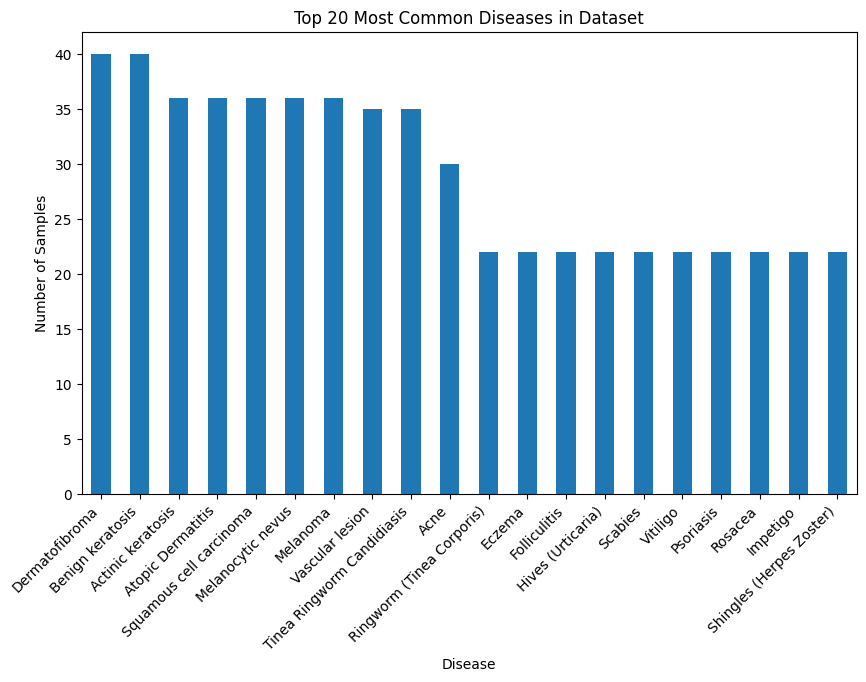

In [ ]:
import matplotlib.pyplot as plt

label_counts = df_light["label"].value_counts()

plt.figure(figsize=(10, 6))
label_counts.head(20).plot(kind="bar")
plt.title("Top 20 Most Common Diseases in Dataset")
plt.xlabel("Disease")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha="right")
plt.show()


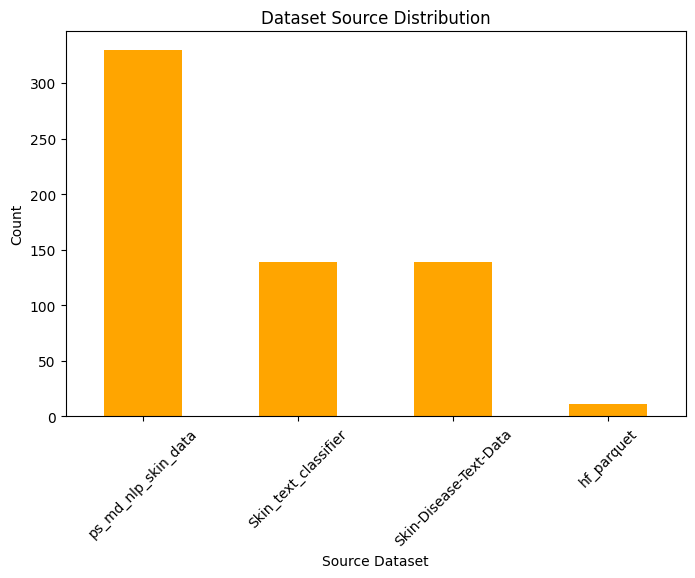

In [ ]:
source_counts = df_light["source"].value_counts()

plt.figure(figsize=(8, 5))
source_counts.plot(kind="bar", color="orange")
plt.title("Dataset Source Distribution")
plt.xlabel("Source Dataset")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


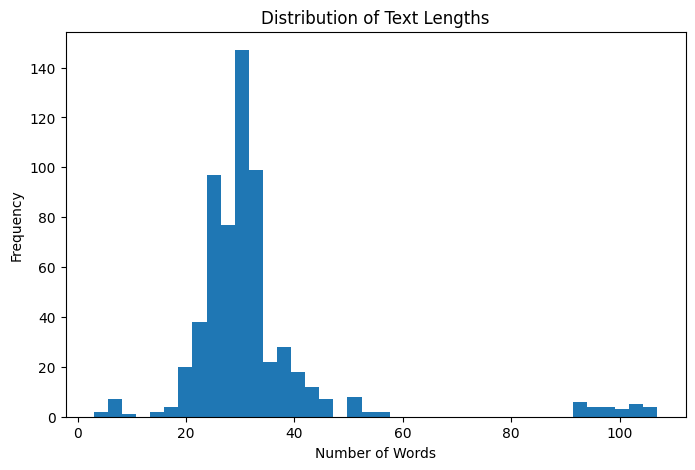

In [ ]:
df_light["text_length"] = df_light["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(8, 5))
df_light["text_length"].plot(kind="hist", bins=40)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

df_data = df_light.copy()

def get_stratify_labels_or_none(labels, min_count=2):
    """
    Returns the labels for stratify only if every class has at least `min_count` samples.
    Otherwise returns None (no stratification).
    """
    vc = labels.value_counts()
    if (vc < min_count).any():
        print(f"[INFO] Not using stratify: some classes have fewer than {min_count} samples.")
        print("Label counts (offending classes):")
        print(vc[vc < min_count])
        return None
    return labels

# === First split: train vs temp (train 70%, temp 30%) ===
stratify_labels = get_stratify_labels_or_none(df_data["label"], min_count=2)

train_df, temp_df = train_test_split(
    df_data,
    test_size=0.30,
    random_state=42,
    stratify=stratify_labels
)

print("After first split:")
print("  train_df:", train_df.shape)
print("  temp_df :", temp_df.shape)

# === Second split: temp -> val + test (50/50) ===
stratify_temp = get_stratify_labels_or_none(temp_df["label"], min_count=2)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    random_state=42,
    stratify=stratify_temp
)

print("\nFinal sizes:")
print("Train size:", train_df.shape[0])
print("Val size  :", val_df.shape[0])
print("Test size :", test_df.shape[0])

print("\nLabel distribution (train, top 20):")
print(train_df["label"].value_counts().head(20))


After first split:
  train_df: (433, 4)
  temp_df : (186, 4)
[INFO] Not using stratify: some classes have fewer than 2 samples.
Label counts (offending classes):
label
Acne vulgaris    1
Name: count, dtype: int64

Final sizes:
Train size: 433
Val size  : 93
Test size : 93

Label distribution (train, top 20):
label
Benign keratosis              28
Dermatofibroma                28
Atopic Dermatitis             25
Actinic keratosis             25
Melanoma                      25
Vascular lesion               25
Tinea Ringworm Candidiasis    25
Melanocytic nevus             25
Squamous cell carcinoma       25
Acne                          21
Vitiligo                      16
Eczema                        16
Impetigo                      16
Hives (Urticaria)             15
Rosacea                       15
Shingles (Herpes Zoster)      15
Psoriasis                     15
Folliculitis                  15
Scabies                       15
Ringworm (Tinea Corporis)     15
Name: count, dtype: int6

In [ ]:
train_path = os.path.join(PROCESSED_DIR, "train.csv")
val_path   = os.path.join(PROCESSED_DIR, "val.csv")
test_path  = os.path.join(PROCESSED_DIR, "test.csv")

train_df.to_csv(train_path, index=False)
val_df.to_csv(val_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved train to:", train_path)
print("Saved val to  :", val_path)
print("Saved test to :", test_path)


Saved train to: /content/drive/MyDrive/SkinAI_Project/data/processed/train.csv
Saved val to  : /content/drive/MyDrive/SkinAI_Project/data/processed/val.csv
Saved test to : /content/drive/MyDrive/SkinAI_Project/data/processed/test.csv
